In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  LassoCV,
                                  Lasso)
#  Lasso, RandomizedLasso are removed, need them later
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd
import os
from sklearn.metrics import r2_score
from scipy.stats import nbinom
# check xgboost version

# evaluate an xgboost regression model on the housing dataset
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance


# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import the train_test_split method
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns
colorvaris = {
    "R":"#BCBEC0",
    'P':'#ea1121',
    'S':'#3BC0CF',
    'poi_gsv':'#016699',
    "gsvalone":"#2F7864",
    "poi":'#ea1121',
    'gsv':'#3BC0CF',
    "core":"#BCBEC0"
             }

In [2]:
targetNames = {
    
    # crime
    "logcrime":"Log(Violent Crime)",
    "logpetty":"Log(Petty Crime)",
          
          # nonvehicle travel
     "walkbike_per_cbg":"%Walk",
    "publictrans_per_cbg":"%Public Transit",
    "drove_alone_per_cbg":"% Drive Alone",
       
          # vehiclde travel
          'estvmiles':"VMT", 
    'estvtrp':"VTRP", 
    'estptrp':"PTRP",  
    'estpmiles':"PMT", 
          
          # health outcome
             "obesitycru":"% Obesity", 
             "bphighcrud":"% High Blood Pressure", 
             "diabetescr":"% Diabetes", 
             "lpacrudepr":"% LPA", 
          "mhlthcrude":"% Mental Health",
    'phlthcrude':"% Physical Health",
    'cancercrud':"% Cancer Health",
          
          # inequality
    "logincome":"Log(Income)",
    "povertyline_below200":"% Poverty Line (200%)",
    "povertyline_below100":"% Poverty Line (100%)",


}

In [64]:
target = [
    # # population

    # crime
    "logcrime",
          
          # nonvehicle travel
            "walkbike_per_cbg",
            "publictrans_per_cbg",
    "drove_alone_per_cbg",
       
          # vehiclde travel
          'estvmiles', 
    'estvtrp', 
    'estptrp', 
    'estpmiles',
          
          # health outcome
             "obesitycru",
             "bphighcrud",
             "diabetescr",
             "lpacrudepr",
          "mhlthcrude",
    'phlthcrude', 
    'cancercrud', 
          
          # inequality

    "logincome",
    "povertyline_below200",
    # "povertyline_below100"
            ]


topicdict = dict(zip(
    target,
    [
        'Crime',
 

     'Non-vehicle Travel', 
        'Non-vehicle Travel',
        'Vehicle Travel',
     
     'Vehicle Travel',
        'Vehicle Travel',
        'Vehicle Travel',
        'Vehicle Travel',
     
     'Health', 'Health',
        'Health','Health','Health',
        'Health','Health',


        'Poverty', 
        'Poverty',
        'Poverty',

     ]
))


plotorderdict = {
    'Vehicle Travel':2,
    'Non-vehicle Travel':1,
    'Health':3,
    'Poverty':4,
    "Crime":5,
    "Population":6

}
colortopics = list(sns.color_palette("husl", 5))
colortopicset = dict(zip(plotorderdict.keys(),colortopics))

tempfolder = "../table/temp"
if not os.path.exists(tempfolder):
    os.makedirs(tempfolder)

In [65]:
graphicsave = "../graphic"
tablefolder = "../table/"
datafolder = "../data"

unit = "cbg" # change here to conduct different analysis

file_name = os.path.join(datafolder, "allparameters.csv")

# preprocessing
df = pd.read_csv(file_name)

# 1. Summary Table

In [30]:
datasum = df[target].describe().T.reset_index().rename(columns ={"index":"target"})
datasum["topic"] = datasum["target"].apply(lambda x: topicdict[x])
datasum.to_csv(os.path.join(tablefolder, "dependentsummary_cbg.csv"), index = False)
datasum.head()

,target,count,mean,std,min,25%,50%,75%,max,topic
0,logcrime,12595.0,1.796018,1.064720,0.00,1.098612,1.791759,2.484907,6.733402,Crime
1,walkbike_per_cbg,37479.0,5.119514,8.971794,0.00,0.000000,1.830000,6.270000,100.000000,Non-vehicle Travel
2,publictrans_per_cbg,37479.0,18.952966,21.809622,0.00,2.675000,9.900000,28.260000,100.000000,Non-vehicle Travel
3,drove_alone_per_cbg,37479.0,61.942063,24.798244,0.00,47.740000,69.970000,80.730000,100.000000,Vehicle Travel
4,estvmiles,35940.0,32.007838,12.456646,4.66,23.690000,32.290000,40.500000,73.700000,Vehicle Travel


In [31]:
# set up model variables
# Set up variable groups

gsv = [
     'facade', 'window', 'recreation', 'road',
       'paving', 'streetfurn', 'landmark', 'plantingt', 'plantingg', 
    'sky',
       'ground', 'nature', 
    'person', 'bike', 'vehicleh', 'vehiclel'
]

gsvnb = [f"{g}_nb" for g in gsv]

loggsvs = []
for p in gsv+gsvnb:
    df[p] = df[p].fillna(0)
    df[f"log{p}"] = np.log(df[p]+1)
    loggsvs.append(f"log{p}")

pois = [
    'agricultur', 'utilites', 'constructi',
       'manufactur', 'wholesalet', 'retail', 'transporta', 'warehouse',
       'informatio', 'finance', 'realestate', 'profession', 'admin',
       'education', 'health', 'arts', 'accommodat', 'publicadmi', 'totalpoi',
    'stationdis', "parkarea_800_cap"
]
poinb = [f"{p}_nb" for p in pois[:-3]]
logpois = []


for p in pois+poinb:
    df[p] = df[p].fillna(0)
    df[f"log{p}"] = np.log(df[p]+1)
    logpois.append(f"log{p}")


variables = logpois+gsv+["geoid"]
dummy = "city"
core = [
    "over65_per_cbg", 
    "poc_cbg",
    "logdistcenter",
    "logpop", 
    "logpopden"]
pop = ["logpop", "logpopden", "logdaypop", "logdaypopden",]
variables = {
    "pop":pop,
    "core":core,
    "poi":logpois,
    "gsv":loggsvs,
    "core+poi+gsv":core + logpois+loggsvs,
    "core+poi":core + logpois,
    "core+gsv":core + loggsvs,
    "poi+gsv":logpois + loggsvs
}
allvaris = set(np.hstack([v for k, v in variables.items()]))
df = df.dropna(subset = allvaris)
# allvaris
df.shape

(37509, 197)

# 1. Direct Regress on GSV feature
1. Train model by each city and test it
2. Train model on each city and test on a different city

In [12]:
def generatedata(df, t, varis,split = 0.7, state=42):
    """
    df: Dataframe
    t: one of the target
    """
    
    XDF = df[varis+[t]].dropna().reset_index(drop = True)
    
    X = XDF[varis]
    Y = XDF[t].values
    scaler = StandardScaler()
    
    X_scaled = scaler.fit_transform(X.values)
    
    # Split data into train and test sets as well as for validation and testing
    train, test, target_train, target_val = train_test_split(X_scaled, 
                                                             Y, 
                                                             train_size = split,
                                                             random_state=state)
    return train, test, target_train, target_val

def evaluateR2(model, test_features, test_labels):
    predictions = model.predict(test_features)
    r2score = r2_score(test_labels, predictions)
    return r2score

def getresult(train, test, target_train, target_val, state):
    
    # reg = LinearRegression(normalize=True)
    # reg.fit(train, target_train)
    reg = LassoCV(cv=5, random_state=state).fit(train, target_train)
    accuracy = {}

    trainr2 =  evaluateR2(reg,  train, target_train)
    testr2 =  evaluateR2(reg, test, target_val)
    
    accuracy["r2"] = {"train":trainr2, "test": testr2}

    perm_importance = permutation_importance(reg, test, target_val)
    coeff = np.abs(reg.coef_)
    # sterror = getstde(lr, test, target_val)
    
    return accuracy, perm_importance, coeff


def plotscatter(x, y, df, style = "city", hue = "target", filename = "plot",figsize = (6,6), reg = True):
    fig, ax = plt.subplots(figsize = figsize)
    ax = sns.scatterplot(x = x, y = y, 
                        data = df, 

                        style=style,
                        s = 100,
                        hue=hue,

                   )
    if reg:
        sns.regplot(x = x, y = y, 
                        data = df, 
                    scatter_kws={"s": 0},
                    robust=True, 
                    ci=95, 
                color = "black",
                    # linewidth = 1,
                ax = ax)
    # maxvalue = np.max([df[x].max(), df[y].max()])
    maxvalue = 0.86 # hardcoded, can change here.
    ax.plot([0, maxvalue+0.05], [0, maxvalue+0.05], linewidth=1, color = 'black', dashes = (10,6))
    plt.legend(fontsize='large', title_fontsize='10', loc='lower left', bbox_to_anchor=(1, 0))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    fig.savefig(os.path.join(graphicsave, f"{filename}.svg"))

In [13]:
def getR2(vari, split, state, df = df):
    varils = variables[vari]
    # print(varils)
    cityorder = []
    targetorder = []

    trainr2 = []
    testr2 = []
    importance = []
    for city in citylist:
        tempdf = df[df["city"]==city].reset_index(drop = True)

        for t in target:
            try:
                train, test, target_train, target_val = generatedata(tempdf, t, varils, split = split, state=state)
                accuracy, perm_importance, coeff = getresult(train, test, target_train, target_val, state)
                trainr2.append(accuracy["r2"]["train"])
                testr2.append(accuracy["r2"]["test"])
                importance.append(perm_importance)
            except:

                trainr2.append(np.nan)
                testr2.append(np.nan)
                importance.append(np.nan)
            cityorder.append(city)
            targetorder.append(t)

    result_city = pd.DataFrame({
            "city":cityorder,
            "target": targetorder,
            "trainR2": trainr2,
            "testR2":testr2,

        })
    result_city["variables"] = vari
    result_city["topic"] = result_city["target"].apply(lambda x: topicdict[x])
    return result_city, importance

In [14]:
split = 0.8
dfsep1 = []
for t in target:
    # make sure for each target and variable, we are using the same data to compare
    tempdf = df[variables["core+poi+gsv"]+[t,"city","logdaypop", "logdaypopden"]].dropna()
    dfsep1.append(tempdf)
dfsep1 = pd.concat(dfsep1).reset_index(drop = True)

In [17]:
# here run all models
result_allstate = {}
fimportance = {}
from tqdm import tqdm
for state in tqdm([2,12,22,32,42,52,62,72,82,92]):
    result_allstate[state] = {}
    result_gsv_city, gsv_importance = getR2("gsv", split, state, dfsep1)
    result_poi_city, poi_importance = getR2("poi", split, state, dfsep1)
    result_poi_gsv_city, poi_gsv_importance = getR2("poi+gsv", split, state, dfsep1)
    result_pop_city, pop_importance = getR2("pop", split,state, dfsep1)
    
    result_core_city, core_importance = getR2("core", split, state, dfsep1)
    result_core_poi_city, core_poi_importance = getR2("core+poi", split, state, dfsep1)
    result_core_gsv_city, core_gsv_importance = getR2("core+gsv", split, state, dfsep1)
    result_core_poi_gsv_city, core_poi_gsv_importance = getR2("core+poi+gsv", split, state, dfsep1)
    
    result_allstate[state]["gsv"] = result_gsv_city
    result_allstate[state]["poi"] = result_poi_city
    result_allstate[state]["poi_gsv"] = result_poi_gsv_city
    result_allstate[state]["pop"] = result_pop_city
    
    result_allstate[state]["core"] = result_core_city
    result_allstate[state]["core+poi"] = result_core_poi_city
    result_allstate[state]["core+gsv"] = result_core_gsv_city
    result_allstate[state]["core+poi+gsv"] = result_core_poi_gsv_city
    fimportance[state] = poi_gsv_importance

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [41:40<00:00, 250.08s/it]


In [18]:
# summarize all model results
# get average result:

statels = [2,12,22,32,42,52,62,72,82,92]

gsvresult = pd.concat([result_allstate[state]["gsv"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
poiresult = pd.concat([result_allstate[state]["poi"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
poigsvresult = pd.concat([result_allstate[state]["poi_gsv"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
popresult = pd.concat([result_allstate[state]["pop"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()

result_core_city = pd.concat([result_allstate[state]["core"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
result_core_poi_city = pd.concat([result_allstate[state]["core+poi"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
result_core_gsv_city = pd.concat([result_allstate[state]["core+gsv"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()
result_corepoigsv_city = pd.concat([result_allstate[state]["core+poi+gsv"] for state in statels]).groupby(["city","topic","variables","target"]).mean().reset_index()


# Fig 1. Compare SVF and POI result

In [21]:
allresult = pd.concat([
    gsvresult,
    poiresult,
    poigsvresult,
    popresult,
    
    result_core_city,
    result_core_poi_city,
    result_core_gsv_city,
    result_corepoigsv_city,

]).reset_index(drop = True)
allresult["spatialres"] = unit

# save this for later
allresult.to_csv(os.path.join(tablefolder, f"{unit}_result.csv"), index = False)
allresult.head()

,city,topic,variables,target,trainR2,testR2,spatialres
0,boston,Crime,gsv,logcrime,0.279144,0.188495,cbg
1,boston,Crime,gsv,logpetty,0.216947,0.134598,cbg
2,boston,Health,gsv,bphighcrud,0.314665,0.314701,cbg
3,boston,Health,gsv,cancercrud,0.487090,0.421091,cbg
4,boston,Health,gsv,diabetescr,0.250089,0.240052,cbg


In [22]:
combineddf = pd.concat([gsvresult, poiresult]).reset_index(drop = True)\
.pivot(columns = "variables", values = "testR2", index = ["city","target","topic"]).reset_index().dropna()


In [23]:
# get correlation
from scipy.stats.stats import pearsonr
combineddf = pd.concat([gsvresult, poiresult]).reset_index(drop = True).pivot(columns = "variables", 
                                                                              values = "testR2", 
                                                                              index = ["city","target","topic"]).reset_index().dropna()
test = combineddf[combineddf["poi"]>0]

corr1 = pearsonr(test["gsv"], test["poi"])

print(f"Model performance R2 on GSV and POI correlated at: \rho = {corr1[0]}, \p = {corr1[1]}")

ho = 0.848406563408487, \p = 3.5989630127445546e-37


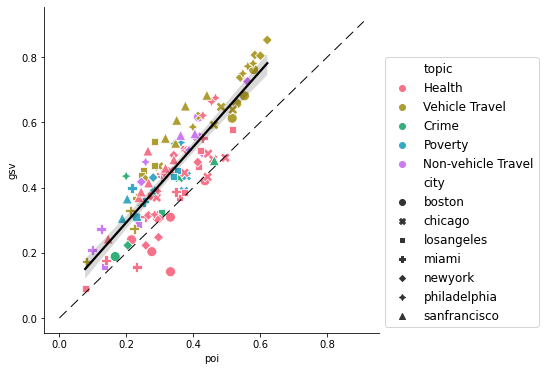

In [67]:
sns.set_palette("husl",len(result_gsv_city["topic"].unique()))
plotscatter( "poi", "gsv",
            test[test["target"].isin(target)],
            "city",
            "topic", 
            
            "Fig1_POI_comparison_cbg",
            figsize = (6,6),
            reg = True) # indicating GSV results are very city specific

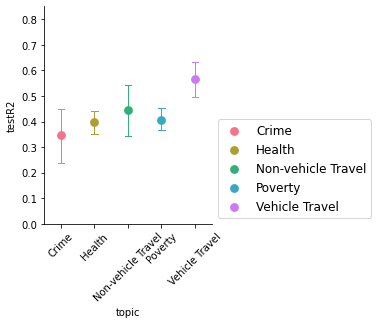

In [80]:
# FIGURE KEEP 1
def plotpredict(result_gsv_city, x, hue, filename):
    fig, ax = plt.subplots(figsize = (3,4))
    sns.set_palette("husl",len(result_gsv_city["topic"].unique()))
    sns.pointplot(
        y  = "testR2",
        x = x,
        hue = hue,
        data = result_gsv_city,
        join=False,
         ci=98,
        capsize = 0.2,
        errwidth = 1
    )
    ax.set(ylim=(0, 0.85))
    # ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])

    plt.legend(fontsize='large', title_fontsize='10', loc='lower left', bbox_to_anchor=(1, 0))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    plt.xticks(rotation=45, size=10)
    
    plt.savefig(os.path.join(graphicsave, f"{filename}.svg"))
    
gsvresult_viz = gsvresult[gsvresult["target"].isin(target)]
plotpredict(gsvresult_viz, "topic", "topic", "gsvall_cbg")

# Other Supplemental Graphics. Compare SVF, POI, and Population

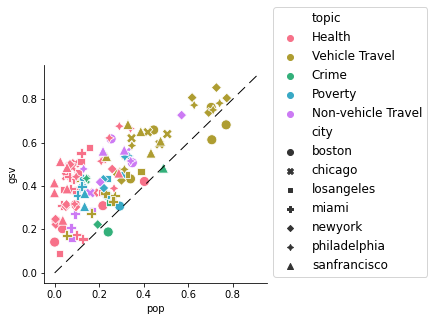

In [68]:
result4 = pd.concat([popresult,
                     poiresult,
                     gsvresult])
result4 = result4[result4["target"].isin(target)]
viz4 = result4.pivot(columns = "variables", 
                     values = "testR2", 
                     index = ["city","target", "topic"]).reset_index().dropna()
viz4 = viz4[viz4["poi"]>0].reset_index(drop = True)

plotscatter("pop","gsv",
            viz4,
            "city",
            "topic", 
            "Fig2_population_comparison_cbg", 
            (4,4),
            reg = False) # indicating GSV results are very city specific

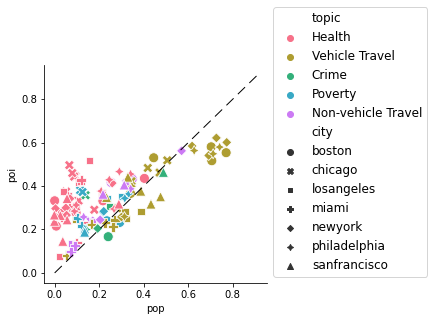

In [69]:
plotscatter("pop","poi",
            viz4,
            "city",
            "topic", 
            "Fig2b_POI_population_comparison_cbg", 
            (4,4),
            reg = False)

In [70]:
# calculate the difference of R2
from scipy import stats
stats.ttest_ind(viz4["gsv"], viz4["pop"])
viz4["gsv-pop"] = viz4["gsv"] - viz4["pop"]

viz4["poi-pop"] = viz4["poi"] - viz4["pop"]
viz4[["poi-pop", "gsv-pop"]].describe()

Ttest_indResult(statistic=9.198969366549623, pvalue=2.1592524493593754e-17)

# 3. Compare SVF's added value

In [74]:
# direct use R2
result6 = pd.concat([result_core_city,
                     poiresult,
                     gsvresult,
                     result_core_gsv_city,
                     result_core_poi_city,
                     poigsvresult,
                     result_core_poi_gsv_city
                    ]).pivot(columns = "variables", 
                             index = ["topic", "city", "target"], 
                             values= "testR2").reset_index()
# result6["topic"] = result6["target"].apply(lambda x:topicdict[x])
result6.head()

variables,topic,city,target,core,core+gsv,core+poi,core+poi+gsv,gsv,poi,poi+gsv
0,Crime,boston,logcrime,0.195222,0.321878,0.273131,0.326498,0.188495,0.166819,0.221598
1,Crime,boston,logpetty,0.092300,0.238125,0.261445,0.293120,0.134598,0.225360,0.261131
2,Crime,chicago,logcrime,0.483265,0.605628,0.570470,0.637854,0.430113,0.357599,0.527657
3,Crime,chicago,logpetty,0.385252,0.574215,0.580893,0.586930,0.329631,0.418816,0.510728
4,Crime,losangeles,logcrime,0.262946,0.441377,0.383982,0.468148,0.324309,0.305960,0.407282


In [75]:
result6["target"].unique()

array(['logcrime', 'logpetty', 'bphighcrud', 'cancercrud', 'diabetescr',
       'lpacrudepr', 'mhlthcrude', 'obesitycru', 'phlthcrude',
       'publictrans_per_cbg', 'walkbike_per_cbg', 'logincome',
       'povertyline_below100', 'povertyline_below200',
       'drove_alone_per_cbg', 'estpmiles', 'estptrp', 'estvmiles',
       'estvtrp'], dtype=object)

In [76]:
result6[result6["target"]=="povertyline_below100"]

variables,topic,city,target,core,core+gsv,core+poi,core+poi+gsv,gsv,poi,poi+gsv
78,Poverty,boston,povertyline_below100,0.168898,0.203890,0.187580,0.224235,0.161876,0.116107,0.180560
81,Poverty,chicago,povertyline_below100,0.214912,0.244453,0.223599,0.292830,0.180091,0.139808,0.214967
84,Poverty,losangeles,povertyline_below100,0.099396,0.137465,0.111429,0.137271,0.116914,0.066766,0.122878
87,Poverty,miami,povertyline_below100,0.107145,0.139680,0.130152,0.104557,0.089751,0.067222,0.098601
90,Poverty,newyork,povertyline_below100,0.144069,0.193020,0.163247,0.208788,0.164325,0.119624,0.183093
93,Poverty,philadelphia,povertyline_below100,0.276324,0.323791,0.283304,0.351552,0.286668,0.183246,0.295840
96,Poverty,sanfrancisco,povertyline_below100,0.073542,0.171482,0.126657,0.218851,0.122640,0.080003,0.146907


In [77]:
viz = result6[result6["target"].isin(target)].reset_index(drop = True)
viz["meancore+gsv"] = viz.groupby("target")["core+gsv"].transform("mean")
# viz = viz.sort_values("meancore+gsv", ascending = False)
viz["order"] = viz["topic"].apply(lambda x: plotorderdict[x])
viz = viz.dropna().sort_values("order").reset_index(drop = True)

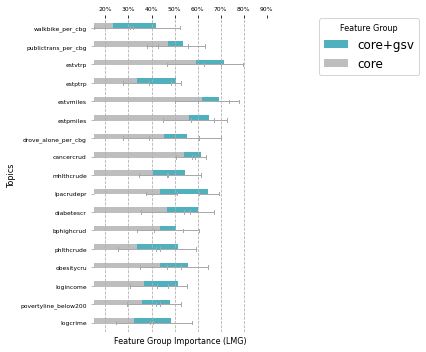

In [78]:
import matplotlib.ticker as mtick
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .3)
        
def compareR2(x1, x2, viz, twobar = True):
    fig, ax = plt.subplots(figsize=(4,5))
    if twobar:
        g = sns.barplot(x=x1,  y="target", data=viz, orient = 'h', color = colorvaris["gsv"], ax = ax,
                   label = x1, 
                        errcolor = "darkgrey",
                        capsize=0.2,
                        errwidth = 1
                       )
    
    s = sns.barplot(x=x2,  y="target", data=viz, orient = 'h', color = colorvaris[x2], ax = ax,
               label =x2,
                    errcolor = "darkgrey",
                    capsize=0.2,
                   errwidth = 1)

    change_width(ax, .30)

    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #     ax.spines['top'].set_color('grey')
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('left')

    ax.grid(which='major', axis='x', linestyle = '--')

    ax.axvline(x = 0, 
                       color = 'white', 
                       linestyle = '-',
                       linewidth = 4)

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    ax.set_xlim(0.15, 0.90)

    ax.tick_params(axis='x', labelsize= 6
                  )
    ax.tick_params(axis='y', labelsize= 6, color = 'darkgrey'
                      )

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.set_xlabel("Feature Group Importance (LMG)", size = 8)

    ax.set_ylabel("Topics", size = 8)
    plt.tight_layout()
    plt.legend(title="Feature Group",
               bbox_to_anchor=(1.3, 1), 
               loc='upper left', 
               borderaxespad=0, fontsize = 'large', title_fontsize = 8)
    plt.savefig(os.path.join(graphicsave, f"{x1}_{x2}_cbg.svg"), transparent = True, dpi = 300)
    
    
compareR2("core+gsv", "core", viz)

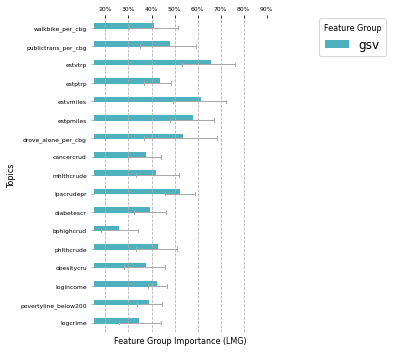

In [79]:
compareR2("core+poi", "gsv", viz, twobar = False)